# INTRODUCTION

Created by: **Colby Cress**

In this notebook, I utilize a Regression Tree model to predict a show's performance using its genres and production countries. Performance, as defined in my team's previous submissions, can be portrayed by any of the following features:
* average_score
* imdb_votes
* tmdb_popularity

The dataset used in this model is my query from the previous assignment; as such the model will be trained with each show's top two genres and some number of its production countries (which will be discussed later in the notebook). Of note is the fact that I had to retroactively go back and keep production_countries in the query, for use in this notebook.

In [152]:
import pandas as pd

# Import the query from my EDA
query_df = pd.read_csv("https://raw.githubusercontent.com/cacress/CSC442/refs/heads/main/datasets/colby_eda.csv")

# query_df.info()

## Wrangle dataset

### Data info before modification

The dataset has the following aspects before modifying it:
* 3166 entries
* 10 columns

In [149]:
print(query_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3166 entries, 0 to 3165
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 3166 non-null   object 
 1   release_year          3166 non-null   int64  
 2   age_certification     2787 non-null   object 
 3   runtime               3166 non-null   int64  
 4   production_countries  3166 non-null   object 
 5   seasons               3166 non-null   float64
 6   imdb_votes            3001 non-null   float64
 7   tmdb_popularity       3166 non-null   float64
 8   top_genres            3166 non-null   object 
 9   average_score         3166 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 247.5+ KB
None


### Get unique genres

In [153]:
import ast

# Unique genres in the dataset
unique_genres = set()

for genres_str in query_df["top_genres"]:
    genres_list = ast.literal_eval(genres_str)
    unique_genres.update(genres_list)

unique_genres = list(unique_genres)
print(unique_genres)

['thriller', 'family', 'scifi', 'animation', 'horror', 'documentation', 'fantasy', 'western', 'action', 'music', 'drama', 'romance', 'crime', 'sport', 'reality', 'comedy', 'war', 'history', 'european']


### Get unique countries

In [154]:
import ast

# Unique production countries in the dataset
unique_countries = set()

for countries_str in query_df["production_countries"]:
    countries_list = ast.literal_eval(countries_str)
    unique_countries.update(countries_list)

unique_countries = list(unique_countries)
print(unique_countries)

['AT', 'XX', 'SA', 'NZ', 'PH', 'BE', 'SY', 'PT', 'IS', 'TR', 'PL', 'KE', 'LU', 'SG', 'MX', 'AE', 'NG', 'US', 'TW', 'EG', 'SE', 'KR', 'IN', 'LB', 'TN', 'BY', 'SN', 'KN', 'DK', 'CN', 'KW', 'HU', 'CL', 'ES', 'GB', 'CZ', 'RU', 'HR', 'HK', 'CA', 'JO', 'CO', 'DE', 'TH', 'IE', 'CH', 'IO', 'FI', 'ZA', 'AR', 'ID', 'MY', 'MA', 'IL', 'NL', 'UA', 'JP', 'FR', 'AU', 'NO', 'PE', 'BR', 'PR', 'IT']


### Create new feature top_unique_countries

In [172]:
import ast

model_df = query_df.copy()

# Convert production_countries to list format
model_df["production_countries"] = model_df["production_countries"].apply(ast.literal_eval)

# Each entry becomes its own row
exploded_df = model_df.explode("production_countries")
country_counts = exploded_df["production_countries"].value_counts()

# Store the top most common countries
top_countries = country_counts.index.tolist()
# print(country_counts)

# Drop rows with empty imdb_votes and tmdb_popularity
model_df = model_df.dropna(subset=["imdb_votes"])
model_df = model_df.dropna(subset=["tmdb_popularity"])

# Drop release_year, age_certification, runtime, and seasons because I determined in the EDA that there may not be a significant connection between these and a show's performance
model_df = model_df.drop(columns=["release_year", "age_certification", "runtime", "seasons"])

model_df = model_df.reset_index(drop=True)

# Convert top_genres to list for consistency
model_df["top_genres"] = model_df["top_genres"].apply(ast.literal_eval)

### Create binary columns for each unique genre and production country

By doing this I provide an easily readable format for the Regression model, where 1 represents if the genre represented by the column name is in top_genres for that entry, and 0 means it is not.

In [156]:
for genre in unique_genres:
  model_df[genre] = model_df["top_genres"].apply(lambda x: 1 if genre in x else 0)

for country in top_countries:
  model_df[country] = model_df["production_countries"].apply(lambda x: 1 if country in x else 0)

### Data info after modification

The dataset has the following aspects before modifying it:
* 3001 entries (115 entries dropped with no entry for imdb_votes)
* 89 columns
 * Dropped release_year, age_certification, runtime, and seasons
 * Created binary column for each unique genre (19 of them)
 * Created binary column for each unique country (64 of them)

In [157]:
print(model_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3001 entries, 0 to 3000
Data columns (total 89 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 3001 non-null   object 
 1   production_countries  3001 non-null   object 
 2   imdb_votes            3001 non-null   float64
 3   tmdb_popularity       3001 non-null   float64
 4   top_genres            3001 non-null   object 
 5   average_score         3001 non-null   float64
 6   thriller              3001 non-null   int64  
 7   family                3001 non-null   int64  
 8   scifi                 3001 non-null   int64  
 9   animation             3001 non-null   int64  
 10  horror                3001 non-null   int64  
 11  documentation         3001 non-null   int64  
 12  fantasy               3001 non-null   int64  
 13  western               3001 non-null   int64  
 14  action                3001 non-null   int64  
 15  music                

## Regression Tree Model Type #1 (CV for just tree depth) [**SUBOPTIMAL** compared to Model Type #2]

### Define functions for reusability

In [158]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from math import sqrt
import sklearn.tree as tree
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def create_training_data(response_variable):
  independent_variables = unique_genres + top_countries

  X = model_df[independent_variables].values
  y = model_df[response_variable].values

  return train_test_split(X, y, test_size=0.3, random_state = 42)

def cross_validate_tree_depth(scoring_method):
  # Define a decision tree regressor model
  model = DecisionTreeRegressor()

  # Define a parameter grid for hyperparameter tuning
  param_grid = {"max_depth": range(2, 101)}

  # Use GridSearchCV to perform cross-validation and find the best depth
  grid_search = GridSearchCV(model, param_grid, cv=5, scoring=make_scorer(scoring_method))

  # Fit the grid search
  grid_search.fit(X_train, y_train)

  # Get the best hyperparameters
  best_depth = grid_search.best_params_["max_depth"]
  print(f"Optimal tree depth: {best_depth}")

  # Optionally, you can also evaluate the best model on the test set:
  best_model = grid_search.best_estimator_
  y_pred = best_model.predict(X_test)

  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)
  rmse = sqrt(mse)
  print(f"Mean Squared Error on Test Set: {mse}")
  print(f"Root Mean Squared Error on Test Set: {rmse}")

  return best_depth

def plot_regression_tree_depth(evaluation_criterion, best_depth):
  # Create the regressor model
  model = DecisionTreeRegressor(criterion=evaluation_criterion, min_samples_split=5, max_depth=best_depth)

  # Fit the model
  model.fit(X_train, y_train)

  # Predict
  y_pred = model.predict(X_test)

  # plt.figure(figsize=(9, 9), dpi=600)
  # tree.plot_tree(model, feature_names=independent_variables, filled=True)

  fig, ax = plt.subplots(figsize=(20, 20), dpi=600)

  # Plot the tree
  tree_plot = tree.plot_tree(model, feature_names=independent_variables, filled=True, ax=ax)

  # Adjust border thickness for each node
  for box in ax.get_children():
      if hasattr(box, "get_linewidth"):
          box.set_linewidth(0.1)

  return y_pred

def report_accuracy():
  mse = mean_squared_error(y_test, y_pred)
  rmse = sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)

  print(f"MSE: {mse}")
  print(f"RMSE: {rmse}")
  print(f"MAE: {mae}")

### Model to predict average_score

#### Create training data

In [159]:
X_train, X_test, y_train, y_test = create_training_data("average_score")

#### Cross-validate for best tree depth

In [160]:
from sklearn.metrics import mean_squared_error

best_depth = cross_validate_tree_depth(mean_squared_error)

Optimal tree depth: 63
Mean Squared Error on Test Set: 0.7874330689267762
Root Mean Squared Error on Test Set: 0.8873742552760793


#### Create and plot regression tree

To view the resulting plot in better detail, click on it to zoom in. Alternatively, download the image and view it in an image-editing software such as Photos.

In [161]:
y_pred = plot_regression_tree_depth("squared_error", best_depth)

#### Report accuracy

An RMSE of 0.9 in this case is good; this means the predictions are about 0.9 points off of the actual average_score, on average.

In [162]:
report_accuracy()

R-squared: -0.0241661429232225
MSE: 0.7844099860841316
RMSE: 0.8856692306296587
MAE: 0.6833463375784397


### Model to predict imdb_votes

#### Create training data

In [163]:
X_train, X_test, y_train, y_test = create_training_data("imdb_votes")

#### Cross-validate for best tree depth

In [164]:
from sklearn.metrics import mean_absolute_error

best_depth = cross_validate_tree_depth(mean_absolute_error)

Optimal tree depth: 75
Mean Squared Error on Test Set: 5548685419.041727
Root Mean Squared Error on Test Set: 74489.4987165421


#### Create and plot regression tree

In [ ]:
y_pred = plot_regression_tree_depth("squared_error", best_depth)

#### Report accuracy

The results for imdb_votes are hard to depict; as there is no upper limit on this column it is difficult to tell what a good MAE is.

In [166]:
report_accuracy()

R-squared: 0.026309721562824517
MSE: 5558140282.76413
RMSE: 74552.93611095495
MAE: 22009.94340285405


### Model to predict tmdb_popularity

#### Create training data

In [71]:
X_train, X_test, y_train, y_test = create_training_data("tmdb_popularity")

#### Cross-validate for best tree depth

In [72]:
from sklearn.metrics import mean_absolute_error

best_depth = cross_validate_tree_depth(mean_absolute_error)

Optimal tree depth: 87
Mean Squared Error on Test Set: 17650.61189450309
Root Mean Squared Error on Test Set: 132.85560543124663


#### Create and plot regression tree

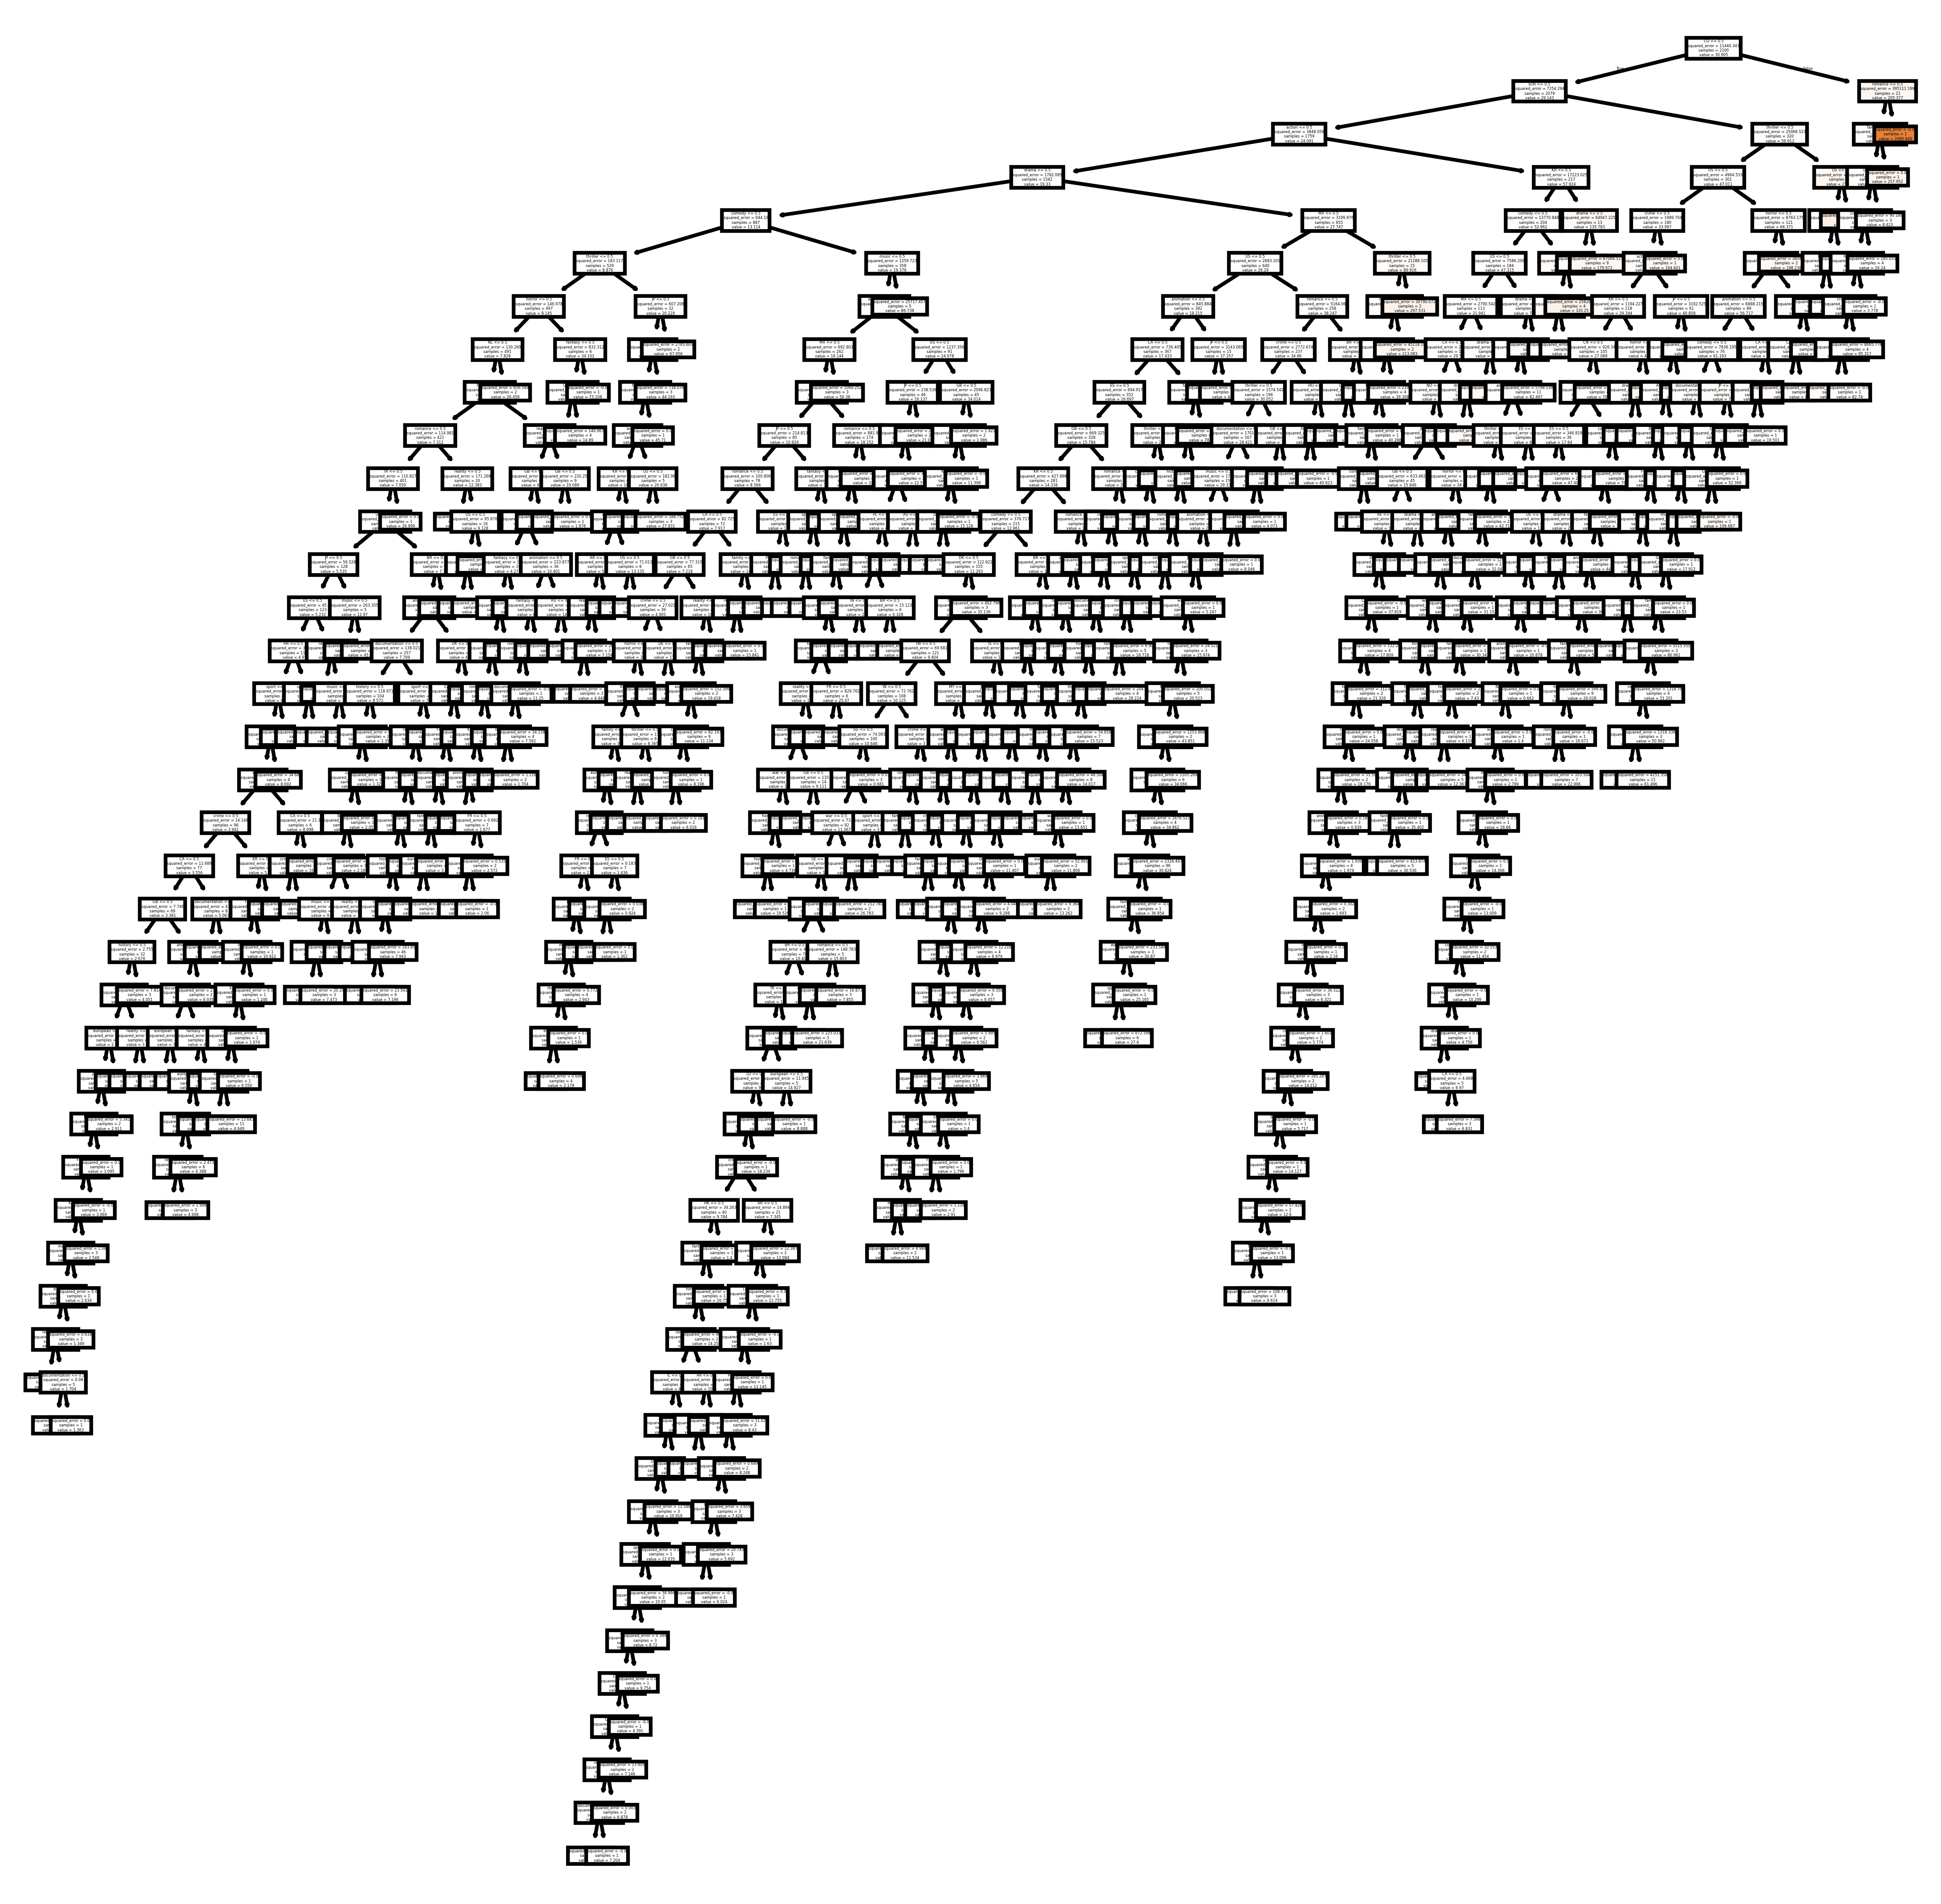

In [74]:
y_pred = plot_regression_tree_depth("squared_error", best_depth)

#### Report accuracy

As with imdb_votes, the results for tmdb_popularity are hard to depict; as there is no upper limit on this column it is difficult to tell what a good RMSE is.

In [75]:
report_accuracy()

R-squared: -1.694453190391001
MSE: 17663.332450005273
RMSE: 132.90347042122443
MAE: 37.9392682143066


## Regression Tree Model Type #2 (CV for tree depth and ccp_alpha)

### Define functions for reusability

In [167]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import sklearn.tree as tree
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def create_training_data(response_variable):
  independent_variables = unique_genres + top_countries

  X = model_df[independent_variables].values
  y = model_df[response_variable].values

  return train_test_split(X, y, test_size=0.3, random_state = 42)

def cross_validate_tree_depth_ccp_alpha(evaluation_criterion, scoring_method):
  # The two ranges of values to be optimized
  param_grid = {"max_depth": range(2, 101), "ccp_alpha": np.linspace(0, 0.02, 100)}

  model = DecisionTreeRegressor(criterion=evaluation_criterion, min_samples_split=5)

  grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring_method)
  grid_search.fit(X_train, y_train)

  print(f"Best {scoring_method} Score: ", grid_search.best_score_)
  print("Best Parameters: ", grid_search.best_params_)

  return grid_search.best_params_

def plot_regression_tree_depth_ccp_alpha(evaluation_criterion, best_params):
  # Create the regressor model
  model = DecisionTreeRegressor(criterion=evaluation_criterion, min_samples_split=5, max_depth=best_params["max_depth"], ccp_alpha=best_params["ccp_alpha"])

  # Fit the model
  model.fit(X_train, y_train)

  # Predict
  y_pred = model.predict(X_test)

  plt.figure(figsize=(9, 9), dpi=300)
  tree.plot_tree(model, feature_names=independent_variables, filled=True);

  return y_pred

def report_accuracy():
  mse = mean_squared_error(y_test, y_pred)
  rmse = sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)

  print(f"MSE: {mse}")
  print(f"RMSE: {rmse}")
  print(f"MAE: {mae}")

### Model to predict average_score

#### Create training data

In [168]:
X_train, X_test, y_train, y_test = create_training_data("average_score")

#### Cross-validate for best tree depth and ccp_alpha

The calculations here can take a while due to the vast range of values explored. It took about 10 minutes to run on my laptop.

In [169]:
best_params = cross_validate_tree_depth_ccp_alpha("squared_error", "neg_mean_squared_error")

Best neg_mean_squared_error Score:  -0.6838457164854844
Best Parameters:  {'ccp_alpha': np.float64(0.008888888888888889), 'max_depth': 54}


#### Create and plot regression tree

In [170]:
y_pred = plot_regression_tree_depth_ccp_alpha("squared_error", best_params)

#### Report accuracy

This model (CV for tree depth & ccp_alpha) is superior to the previous one (CV for just tree depth) in almost every manner. While this model takes much longer to evaluate and creates a much simpler tree, it is more accurate, typically being more accurate by 0.1 points on the RMSE (~0.8 vs. the other model's ~0.9).

In [171]:
report_accuracy()

R-squared: 0.08250667161105318
MSE: 0.7027091589843834
RMSE: 0.8382774952152678
MAE: 0.6387243151699579


### Model to predict imdb_votes

#### Create training data

In [87]:
X_train, X_test, y_train, y_test = create_training_data("imdb_votes")

#### Cross-validate for best tree depth and ccp_alpha

In [88]:
best_params = cross_validate_tree_depth_ccp_alpha("squared_error", "neg_mean_squared_error")

Best neg_mean_squared_error Score:  -3750560629.6762643
Best Parameters:  {'ccp_alpha': np.float64(0.0), 'max_depth': 3}


#### Create and plot regression tree

In [89]:
y_pred = plot_regression_tree_depth_ccp_alpha("squared_error", best_params)

#### Report accuracy

In [90]:
report_accuracy()

R-squared: 0.04744255149498089
MSE: 5437507227.329653
RMSE: 73739.4550246315
MAE: 21986.420050483266


### Model to predict tmdb_popularity

#### Create training data

In [91]:
X_train, X_test, y_train, y_test = create_training_data("tmdb_popularity")

#### Cross-validate for best tree depth and ccp_alpha

In [92]:
best_params = cross_validate_tree_depth_ccp_alpha("squared_error", "neg_mean_squared_error")

Best neg_mean_squared_error Score:  -11099.93807506152
Best Parameters:  {'ccp_alpha': np.float64(0.00202020202020202), 'max_depth': 3}


#### Create and plot regression tree

In [93]:
y_pred = plot_regression_tree_depth_ccp_alpha("squared_error", best_params)

#### Report accuracy

In [94]:
report_accuracy()

R-squared: -1.5777307113591936
MSE: 16898.164972284718
RMSE: 129.99294200949802
MAE: 36.92241525475563
